
**Members**:  Melahat Tayli, Arjun Singh, Artemio Mendoza-Garcia, Paulo Silva, Wa’il Choudar


<hr style="height:2pt">

## APENDIX A

This notebook contains our initial modeling efforts. Although we ultimately decided to use a different direction in the main notebook, the code shown here may be useful for developing new ideas or improving upon our original work. Additionally, it is important to note that the code in this notebook may have limitations or drawbacks that were not addressed in our final model, and should be carefully evaluated before being used in any further analysis.

<a id="contents"></a>

## Notebook contents

- [**STEP 1: EDA and Data Cleansing**](#part1)


- [**STEP 2: Feature Engineering**](#part2)


- [**STEP 3: Tokenization and Categorization**](#part3)


- [**STEP 4: Train / Validation / Test Split**](#part4)


- [**STEP 5: Predicting 'fullPrice'**](#part5)


- [**STEP 6: Simple Boosting**](#part6)


- [**STEP 7: Predicting color-FullPrice**](#part7)


- [**STEP 8: Naive Feature Reduction**](#part8) 

In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import CountVectorizer

from tqdm import tqdm

# XGBoost
# !pip install xgboost
#!pip install gensim
# !pip install python-Levenshtein

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string

import xgboost
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score


# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

import re
from datetime import date, datetime

%matplotlib inline

---

---

<a id="part1"></a>
## STEP 1: EDA and Data Cleansing

In [3]:
initial_time=datetime.now()        

# Keep Process Baseline = True to process final project data
_PROCESS_BASELINE = True
_SAVE_TO_DISK = False

# Reads scraped data
if _PROCESS_BASELINE:
    INPUT_FILE  = 'data/nike_30NOV2022_2335.csv'
    OUTPUT_FILE = 'data/nike_EDA_05DEC22.csv'

else:
    INPUT_FILE = 'data/nike_06DEC2022_1708.csv'
    OUTPUT_FILE = 'data/nike_EDA_06DEC2022.csv'

nike = pd.read_csv(INPUT_FILE)
nike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5085 entries, 0 to 5084
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             5085 non-null   int64  
 1   UID                    5085 non-null   object 
 2   cloudProdID            5085 non-null   object 
 3   productID              5085 non-null   object 
 4   shortID                5085 non-null   object 
 5   colorNum               5085 non-null   int64  
 6   title                  5085 non-null   object 
 7   subtitle               5085 non-null   object 
 8   category               5085 non-null   object 
 9   type                   5085 non-null   object 
 10  currency               5085 non-null   object 
 11  fullPrice              5085 non-null   int64  
 12  currentPrice           5085 non-null   float64
 13  sale                   5085 non-null   bool   
 14  TopColor               5085 non-null   object 
 15  chan

In [4]:
nike.describe()

,Unnamed: 0,colorNum,fullPrice,currentPrice,rating,prebuildId,color-FullPrice,color-CurrentPrice
count,5085.000000,5085.000000,5085.000000,5085.000000,4911.000000,9.500000e+01,5085.000000,5085.000000
mean,2772.487119,3.490659,106.367355,94.571575,3.726145,5.950898e+09,106.375805,93.984173
std,1683.567069,3.314632,48.002843,47.013372,1.827047,2.387346e+09,48.071881,46.942730
min,0.000000,1.000000,25.000000,13.970000,0.000000,1.531389e+09,25.000000,13.970000
25%,1309.000000,1.000000,70.000000,60.000000,4.000000,4.232192e+09,70.000000,59.970000
50%,2696.000000,2.000000,100.000000,85.000000,4.600000,5.622280e+09,100.000000,85.000000
75%,4229.000000,5.000000,140.000000,125.000000,4.800000,7.968067e+09,140.000000,125.000000
max,5880.000000,32.000000,350.000000,305.000000,5.000000,9.991851e+09,350.000000,305.000000


In [5]:
nike.head()

,Unnamed: 0,UID,cloudProdID,productID,shortID,colorNum,title,subtitle,category,type,currency,fullPrice,currentPrice,sale,TopColor,channel,short_description,rating,customizable,ExtendedSizing,inStock,ComingSoon,BestSeller,Excluded,GiftCard,Jersey,Launch,MemberExclusive,NBA,NFL,Sustainable,label,prebuildId,prod_url,color-ID,color-Description,color-FullPrice,color-CurrentPrice,color-Discount,color-BestSeller,color-InStock,color-MemberExclusive,color-New,color-Label,color-Image-url
0,0,43070a72-0b17-56cf-8335-aef1ff9dd04843070a72-0...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,1,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,43070a72-0b17-56cf-8335-aef1ff9dd048,Black/Anthracite/Habanero Red/Phantom,120.0,58.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."
1,1,43070a72-0b17-56cf-8335-aef1ff9dd048b4acd5f7-f...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,2,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,b4acd5f7-f71e-51ae-92d4-12af42c6d63f,Archaeo Pink/Metallic Mahogany/Dark Beetroot/L...,120.0,84.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."
2,2,43070a72-0b17-56cf-8335-aef1ff9dd0483426a9a3-a...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,3,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,3426a9a3-ab9f-5ecd-97ca-f7da1f90b623,White/Black,120.0,84.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."
3,3,43070a72-0b17-56cf-8335-aef1ff9dd048777d62b6-d...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,4,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,777d62b6-d083-58d1-9d68-a49cebbbee57,Black/Hyper Crimson/Metallic Silver,120.0,58.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."
4,4,43070a72-0b17-56cf-8335-aef1ff9dd048ac42be38-8...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,5,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,ac42be38-8dce-5d9c-94ec-ff54058cf3e4,White/Black/Chutney/Volt,120.0,72.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."


### Removes the first rows and drops columns with too many NaNs

In [6]:
# Removes the first rows and drops column "prebuild" as it has too many NaNs
df = nike.iloc[:,4:]
df.drop('prebuildId', axis=1, inplace=True)

In [7]:
# How many missing descriptions and ratings?
missing_desc = len(df[df['short_description'].isna()]['shortID'])
missing_ratings =  len(df[df['rating'].isna()]['shortID'])
total_rows = len(df)

print(f'total rows:{total_rows}: missing descriptions {missing_desc} {round(missing_desc/total_rows*100,2)}%, missing ratings {missing_ratings} {round(missing_ratings/total_rows*100,2)}%')

total rows:5085: missing descriptions 62 1.22%, missing ratings 174 3.42%


In [8]:
# This are too few rows, we can drop them
df = df.dropna()
print(f'number of rows left: {len(df)}')

number of rows left: 4910


### Encode Subcategory

In [9]:
# Add a subcategory 
df['subcategory']='unknown'

subcategories = [{'Women':'woman'},{'^Men':'man'},{'Kids':'kid'},
                 {'Big Kid':'big_kid'},{'Boy':'boy'},
                {'Little Kid':'little_kids'},{'Baby/Toddler':'baby_toddler'},
                {'Infant/Toddler':'infant_toddler'},{'Unisex':'unisex'},
                {'Toddler':'toddler'},{'Baby':'baby'},{'Crib':'baby'}]


for item in subcategories:
    
    subcategory = list(item.values())[0]
    name = list(item.keys())[0]
    
    count = 0
    
    for index in df.loc[df['subtitle'].str.contains(name,case=False)].index:
        df.loc[index,'subcategory'] = subcategory
        count += 1

1023 rows from Women set as woman
1499 rows from ^Men set as man
1101 rows from Kids set as kid
695 rows from Big Kid set as big_kid
2 rows from Boy set as boy
408 rows from Little Kid set as little_kids
404 rows from Baby/Toddler set as baby_toddler
25 rows from Infant/Toddler set as infant_toddler
7 rows from Unisex set as unisex
433 rows from Toddler set as toddler
419 rows from Baby set as baby
14 rows from Crib set as baby


---

<a id="part2"></a>
## STEP 2: Feature Engineering

### How many unique values do we have?

In [16]:
# How many unique values do we have?
df.iloc[:,2:].nunique()

title                     903
subtitle                  190
category                   14
type                        1
currency                    1
fullPrice                  72
currentPrice              192
sale                        2
TopColor                 1199
channel                     3
short_description        1423
rating                     28
customizable                1
ExtendedSizing              1
inStock                     2
ComingSoon                  2
BestSeller                  2
Excluded                    1
GiftCard                    1
Jersey                      1
Launch                      1
MemberExclusive             2
NBA                         1
NFL                         1
Sustainable                 2
label                       6
prod_url                 1640
color-ID                 4634
color-Description        2960
color-FullPrice            78
color-CurrentPrice        226
color-Discount              2
color-BestSeller            2
color-InSt

### We can delete all fields with a single value, because they don't have information


In [17]:
# we can delete all fields with a single value, because they don't have information

df.drop([
    'type',
    'currency',
    'customizable',
    'ExtendedSizing',
    'BestSeller',
    'Excluded',
    'NFL',
    'NBA',
    'Launch',
    'Jersey',
    'GiftCard'
],axis=1, inplace=True)

In [18]:
# Also, there are several predictors at the TopColor shows only the first color of the model, we don't need this column
df.loc[:10][['TopColor','colorNum','color-Description']]

,TopColor,colorNum,color-Description
0,Black/Anthracite/Habanero Red/Phantom,1,Black/Anthracite/Habanero Red/Phantom
1,Black/Anthracite/Habanero Red/Phantom,2,Archaeo Pink/Metallic Mahogany/Dark Beetroot/L...
2,Black/Anthracite/Habanero Red/Phantom,3,White/Black
3,Black/Anthracite/Habanero Red/Phantom,4,Black/Hyper Crimson/Metallic Silver
4,Black/Anthracite/Habanero Red/Phantom,5,White/Black/Chutney/Volt
5,Black/Anthracite/Habanero Red/Phantom,6,Green Glow/Infinite Lilac/Laser Orange/Dark Sm...
6,Black/Volt/Anthracite/White,1,Black/Volt/Anthracite/White
7,Black/Volt/Anthracite/White,2,Crimson Bliss/Total Orange/Pearl White
8,Black/Volt/Anthracite/White,3,White/Mint Foam/Laser Blue/Black


In [19]:
# drop TopColor and URLs
# At shoe Level

df.drop(['prod_url','color-Image-url'],axis=1, inplace=True)

# At Color Level 
# df.drop(['TopColor','prod_url','color-Image-url'],axis=1, inplace=True)

### This looks better, no predictors with a single value

In [20]:
# this looks better, no predictors with a single value
df.nunique()

shortID                  1640
colorNum                   32
title                     903
subtitle                  190
category                   14
fullPrice                  72
currentPrice              192
sale                        2
TopColor                 1199
channel                     3
short_description        1423
rating                     28
inStock                     2
ComingSoon                  2
MemberExclusive             2
Sustainable                 2
label                       6
color-ID                 4634
color-Description        2960
color-FullPrice            78
color-CurrentPrice        226
color-Discount              2
color-BestSeller            2
color-InStock               2
color-MemberExclusive       2
color-New                   2
color-Label                 6
subcategory                10
dtype: int64

### We have several predictors at the Product Level and also at Color Level. 
#### Let's analyze if we need both and see if there are discounted shoes with no discount at color level

In [21]:

discounted = df[df['sale']==True]
idx = discounted[discounted['color-Discount']==False]['shortID']
df[df['shortID'].isin(idx)][['title','colorNum','fullPrice','sale','color-Discount','color-CurrentPrice']]


,title,colorNum,fullPrice,sale,color-Discount,color-CurrentPrice
119,Air Jordan 11 CMFT Low,1,130,True,True,110.97
120,Air Jordan 11 CMFT Low,2,130,True,False,130.00
121,Air Jordan 11 CMFT Low,3,130,True,False,130.00
122,Air Jordan 11 CMFT Low,4,130,True,False,130.00
224,Jordan Max Aura,1,120,True,True,95.97
...,...,...,...,...,...,...
4939,Nike Force 1,2,50,True,False,55.00
4940,Nike Force 1,3,50,True,False,55.00
4941,Nike Force 1,4,50,True,False,55.00
4978,Air Max 90 LTR,1,140,True,True,112.97


#### Are there Shoes flagged as not discounted, but with discounted at color level?


In [22]:
discounted = df[df['sale']==False]
idx = discounted[discounted['color-Discount']==True]['shortID']
df[df['shortID'].isin(idx)][['title','colorNum','fullPrice','sale','color-Discount','color-CurrentPrice']]


,title,colorNum,fullPrice,sale,color-Discount,color-CurrentPrice
40,Jordan Max Aura 4,1,125,False,False,125.00
41,Jordan Max Aura 4,2,125,False,False,125.00
42,Jordan Max Aura 4,3,125,False,True,106.97
43,Jordan Max Aura 4,4,125,False,False,125.00
44,Jordan Max Aura 4,5,125,False,True,106.97
...,...,...,...,...,...,...
4972,Nike Air Max Axis,2,80,False,True,54.97
4981,Nike Air Max Thea Mid,2,150,False,True,120.97
5018,Nike Force 1 Crater Next Nature,1,60,False,False,60.00
5019,Nike Force 1 Crater Next Nature,2,60,False,True,50.97


#### We can conclude that it is better to drop the sale indicator at the product level and keep the discount indicator at the color level instead, because it has more explanatory power.
Similarly, we can drop the fullPrice and currentPrice indicators at the product level and keep them at the color level.

By conducting similar analysis, we conclude that the "label" predictor is redundant because we already have the "color-label" predictor.

Similarly, other predictors at the product level that have detailed information at the color level can be dropped.

In [23]:
# Before Droping, creating extra flags at color level, for label

#lets add label "JustIn" and remove color-label
df['color-just_in']=False
df['color-just_in'] = np.where(df['color-Label'] == 'JUST_IN', True, False)

# Add column Sold Out
df['color-sold_out'] = False
df['color-sold_out'] = np.where(df['color-Label'] == 'SOLD_OUT', True, False)

# Add column In Stock
df['color-coming_soon'] = False
df['color-coming_soon'] = np.where(df['color-Label'] == 'COMING_SOON', True, False)

In [24]:
# Droping redundant labels at Shoe Level
df.drop(['sale','label','inStock','MemberExclusive','ComingSoon','color-Label'], axis=1, inplace=True)

#### What about Color description?


In [25]:
df['color-Description']

0                   Black/Anthracite/Habanero Red/Phantom
1       Archaeo Pink/Metallic Mahogany/Dark Beetroot/L...
2                                             White/Black
3                     Black/Hyper Crimson/Metallic Silver
4                                White/Black/Chutney/Volt
                              ...                        
5079     Light Madder Root/Crimson Bliss/Cave Stone/White
5080                              White/Dark Sulfur/Black
5081                      Black/White/Black/Varsity Royal
5083                   Black/Gum Light Brown/Orange/White
5084    University Blue/Vivid Green/Team Orange/Citron...
Name: color-Description, Length: 4910, dtype: object

#### What about channels? this is a categorical variable, we need to take care of it

In [26]:
df['channel'].unique()

array(["['NikeApp', 'Nike.com', 'Nike Store Experiences']",
       "['SNKRS', 'NikeApp', 'Nike.com', 'Nike Store Experiences']",
       "['Nike.com', 'Nike Store Experiences']"], dtype=object)

In [27]:
# Add channel SNKRS
df['channel_SNKRS'] = False
df['channel_SNKRS'] = np.where(df['channel'] == "['SNKRS', 'NikeApp', 'Nike.com', 'Nike Store Experiences']", True, False)

In [28]:
# Add channel nikeApp
df['channel_nikeApp'] = False
df['channel_nikeApp'] = np.where(df['channel'] == "['NikeApp', 'Nike.com', 'Nike Store Experiences']", True, False)

In [29]:
# And we can delete channel, and the IDs for Product and Color 
df.drop(['channel'],axis=1, inplace=True)

df.drop(['shortID','color-ID'], axis=1,inplace=True)

### Ready to save our base line (before vectorization) to disk!

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4910 entries, 0 to 5084
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   colorNum               4910 non-null   int64  
 1   title                  4910 non-null   object 
 2   subtitle               4910 non-null   object 
 3   category               4910 non-null   object 
 4   fullPrice              4910 non-null   int64  
 5   currentPrice           4910 non-null   float64
 6   TopColor               4910 non-null   object 
 7   short_description      4910 non-null   object 
 8   rating                 4910 non-null   float64
 9   Sustainable            4910 non-null   bool   
 10  color-Description      4910 non-null   object 
 11  color-FullPrice        4910 non-null   float64
 12  color-CurrentPrice     4910 non-null   float64
 13  color-Discount         4910 non-null   bool   
 14  color-BestSeller       4910 non-null   bool   
 15  colo

### Backup Data

In [31]:
df_backup = df.copy()

---

<a id="part3"></a>
## STEP 3: Tokenization and Categorization

### Helpful functions for splitting up the data and merging into a dataframe

In [32]:
def encode(column, data):
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(data[[column]])
    new_cols = pd.DataFrame(ohe.transform(data[[column]]), 
                            columns=ohe.get_feature_names(input_features=[column]),
                            index=data.index
                           )
    data = pd.concat([data, new_cols], axis=1)
    return data

In [33]:
def tokenize(column, data):
    vect = CountVectorizer(stop_words="english")
    vect.fit(data[column])
    new_cols = pd.DataFrame(
        vect.transform(data[column]).toarray(), 
        columns=[f"{column}_{feat}" for feat in vect.get_feature_names()],
        index=data.index
    )
    data = pd.concat([data, new_cols], axis=1)
    return data

### Categorical Encodings

In [34]:
df.category

0         cycling
1         cycling
2         cycling
3         cycling
4         cycling
          ...    
5079    lifestyle
5080    lifestyle
5081    lifestyle
5083    lifestyle
5084    lifestyle
Name: category, Length: 4910, dtype: object

In [35]:
df.category.unique()

array(['cycling', 'jordan', 'running', 'golf', 'training', 'tennis',
       'football', 'basketball', 'boot', 'baseball', 'soccer', 'hiit',
       'volleyball', 'lifestyle'], dtype=object)

In [36]:
df.subcategory.unique()

array(['woman', 'baby', 'man', 'unknown', 'big_kid', 'boy', 'toddler',
       'little_kids', 'unisex', 'kid'], dtype=object)

In [37]:
df = df_backup.copy()
df = encode("subcategory", df)
df = encode("category", df)

### Token Counts

In [38]:
df = tokenize("title", df)
df = tokenize("subtitle", df)
df = tokenize("TopColor", df)
df = tokenize("short_description", df)
df = tokenize("color-Description", df)

### Larger Feature Space

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4910 entries, 0 to 5084
Columns: 6008 entries, colorNum to color-Description_zitron
dtypes: bool(11), float64(28), int64(5962), object(7)
memory usage: 224.9+ MB


In [40]:
df.columns

Index(['colorNum', 'title', 'subtitle', 'category', 'fullPrice', 'currentPrice', 'TopColor', 'short_description', 'rating', 'Sustainable',
       ...
       'color-Description_whisper', 'color-Description_white', 'color-Description_wild', 'color-Description_wine', 'color-Description_wolf', 'color-Description_worn', 'color-Description_wow', 'color-Description_yellow', 'color-Description_zen', 'color-Description_zitron'], dtype='object', length=6008)

---

<a id="part4"></a>
## STEP 4: Train / Validation / Test Split

### Splits

80/20 Train/Test split. Similarly 80/20 sub/val split of train.

In [41]:
train, test = train_test_split(df, test_size=0.2, random_state=0)
sub, val = train_test_split(train, test_size=0.2, random_state=0)

### Utility for selecting groups of columns

In [42]:
def select_text(column, data):
    return [col for col in data.columns if f"{column}_" == col[:len(column)+1]]

### Groups of Columns

In [43]:
# TopColor doesnt make any sense
# We dont want to include ANY pricing information
# We dont want to include ANY information collected after the release of the shoe

text_cats = ["title", "subtitle", "short_description"]
text_cols = [word for cat in text_cats for word in select_text(cat, df)]
ctgr_cats = ["category", "subcategory", "channel"]
ctgr_cols = [word for cat in ctgr_cats for word in select_text(cat, df)]
othr_cols = ["colorNum","Sustainable"]

subset_cols = text_cols + ctgr_cols + othr_cols

---

<a id="part5"></a>
## STEP 5: Predicting 'fullPrice'

### Baseline Model

#### Utility for visualizing Depth vs MAE/MSE

In [44]:
def viz_regression_depth(title):
    fig, ax = plt.subplots(1, 2, figsize= (16,5))

    fig.suptitle(title)

    ax[0].plot(depths, train_mae, ".-", label="sub MAE")
    ax[0].plot(depths, val_mae, ".-", label="val MAE")
    ax[0].set_xlabel("Depth")
    ax[0].set_ylabel("MAE")
    ax[0].set_title("Depth vs MAE")
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(depths, train_mse, ".-", label="sub MSE")
    ax[1].plot(depths, val_mse, ".-", label="val MSE")
    ax[1].set_xlabel("Depth")
    ax[1].set_ylabel("MSE")
    ax[1].set_title("Depth vs MSE")
    ax[1].legend()
    ax[1].grid()

#### Tokens derived from title

In [45]:
title_cols = select_text("title", df)

#### DecisionTreeRegressor predicting fullPrice using only title token counts

In [46]:
train_mae = []
train_mse = []
val_mae = []
val_mse = []

depths = list(range(5, 101, 5))

for max_depth in tqdm(depths):
    rfr = DecisionTreeRegressor(max_depth=max_depth)
    rfr.fit(sub[title_cols], sub["fullPrice"])
    
    x_sub_pred = rfr.predict(sub[title_cols])
    x_val_pred = rfr.predict(val[title_cols])
    
    train_mae.append(mean_absolute_error(x_sub_pred, sub["fullPrice"]))
    train_mse.append(mean_squared_error(x_sub_pred, sub["fullPrice"]))
    val_mae.append(mean_absolute_error(x_val_pred, val["fullPrice"]))
    val_mse.append(mean_squared_error(x_val_pred, val["fullPrice"]))

100%|██████████| 20/20 [00:01<00:00, 11.41it/s]


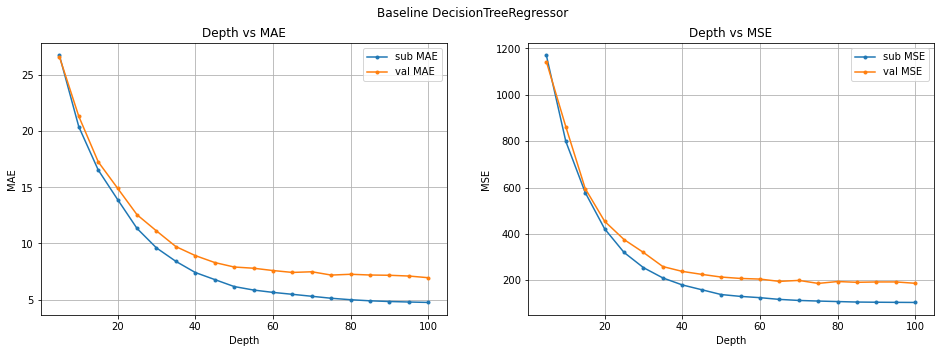

In [47]:
viz_regression_depth("Baseline DecisionTreeRegressor")

---

### RandomForest using Title

#### Train RandomForestRegressor at various depths on fullPrice using Title

In [48]:
train_mae = []
train_mse = []
val_mae = []
val_mse = []

depths = list(range(5, 101, 5))

for max_depth in tqdm(depths):
    rfr = RandomForestRegressor(n_estimators=100, max_depth=max_depth)
    rfr.fit(sub[title_cols], sub["fullPrice"])
    
    x_sub_pred = rfr.predict(sub[title_cols])
    x_val_pred = rfr.predict(val[title_cols])
    
    train_mae.append(mean_absolute_error(x_sub_pred, sub["fullPrice"]))
    train_mse.append(mean_squared_error(x_sub_pred, sub["fullPrice"]))
    val_mae.append(mean_absolute_error(x_val_pred, val["fullPrice"]))
    val_mse.append(mean_squared_error(x_val_pred, val["fullPrice"]))

100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


---

---

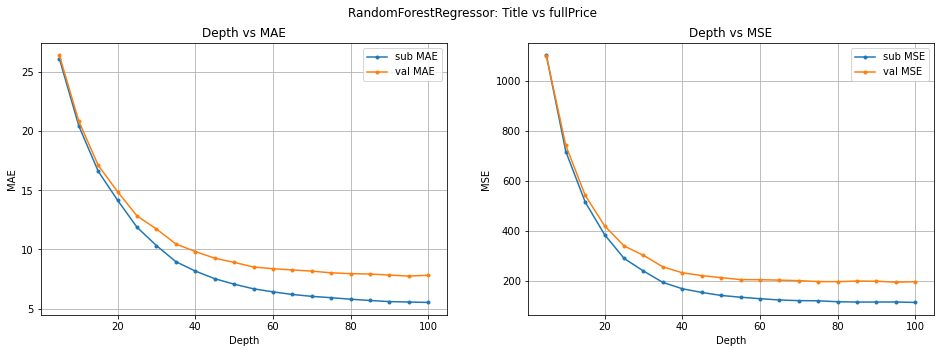

In [49]:
viz_regression_depth("RandomForestRegressor: Title vs fullPrice")

---

### RandomForestRegressor using all shoe-level

In [50]:
train_mae = []
train_mse = []
val_mae = []
val_mse = []

depths = list(range(5, 101, 5))

for max_depth in tqdm(depths):
    rfr = RandomForestRegressor(n_estimators=100, max_depth=max_depth)
    rfr.fit(sub[subset_cols], sub["fullPrice"])
    
    x_sub_pred = rfr.predict(sub[subset_cols])
    x_val_pred = rfr.predict(val[subset_cols])
    
    train_mae.append(mean_absolute_error(x_sub_pred, sub["fullPrice"]))
    train_mse.append(mean_squared_error(x_sub_pred, sub["fullPrice"]))
    val_mae.append(mean_absolute_error(x_val_pred, val["fullPrice"]))
    val_mse.append(mean_squared_error(x_val_pred, val["fullPrice"]))

100%|██████████| 20/20 [14:53<00:00, 44.66s/it]


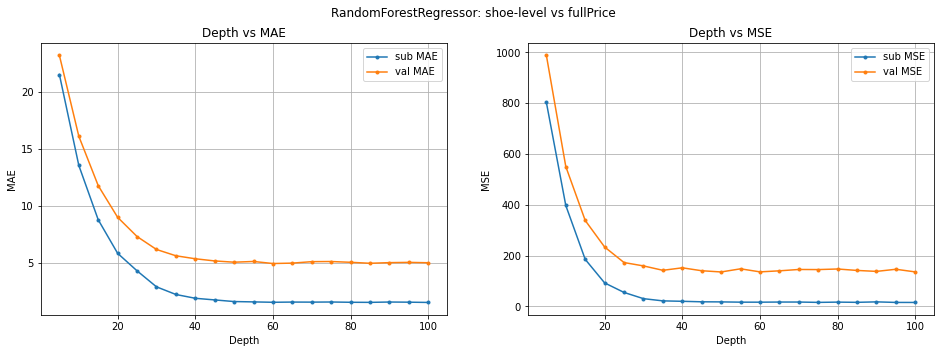

In [51]:
viz_regression_depth("RandomForestRegressor: shoe-level vs fullPrice")

#### Val MAE/MSE levels off at about depth=45. Selecting the best depth and re-training.

In [52]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=45)
rfr.fit(sub[subset_cols], sub.fullPrice)

x_sub_pred = rfr.predict(sub[subset_cols])
x_val_pred = rfr.predict(val[subset_cols])

print("Val MAE:", mean_absolute_error(x_val_pred, val.fullPrice))
print("Val MSE:", mean_squared_error(x_val_pred, val.fullPrice))

Val MAE: 5.150916323628631
Val MSE: 147.94916965723857


In [53]:
# fig, ax = plt.subplots(1, 2, figsize= (16,5))

# fig.suptitle("RandomForestRegressor: All shoe-level vs fullPrice")

# ax[0].plot(depths, train_mae, ".-", label="sub MAE")
# ax[0].plot(depths, val_mae, ".-", label="val MAE")
# ax[0].set_xlabel("Depth")
# ax[0].set_ylabel("MAE")
# ax[0].set_title("Depth vs MAE")
# ax[0].legend()
# ax[0].grid()

# ax[1].plot(depths, train_mse, ".-", label="sub MSE")
# ax[1].plot(depths, val_mse, ".-", label="val MSE")
# ax[1].set_xlabel("Depth")
# ax[1].set_ylabel("MSE")
# ax[1].set_title("Depth vs MSE")
# ax[1].legend()
# ax[1].grid()

---

<a id="part6"></a>
## STEP 6: Simple Boosting

In [54]:
depths = list(range(1, 21))

train_mae = []
train_mse = []
val_mae = []
val_mse = []

for depth in depths:
    difference = sub.fullPrice - x_sub_pred

    rfr2 = DecisionTreeRegressor(max_depth=depth)
    rfr2.fit(sub[text_cols], difference)

    x_sub_pred2 = rfr2.predict(sub[text_cols])
    x_val_pred2 = rfr2.predict(val[text_cols])

    train_mae.append(mean_absolute_error(x_sub_pred2 + x_sub_pred, sub.fullPrice))
    train_mse.append(mean_squared_error(x_sub_pred2 + x_sub_pred, sub.fullPrice))
    val_mae.append(mean_absolute_error(x_val_pred2 + x_val_pred, val.fullPrice))
    val_mse.append(mean_squared_error(x_val_pred2 + x_val_pred, val.fullPrice))

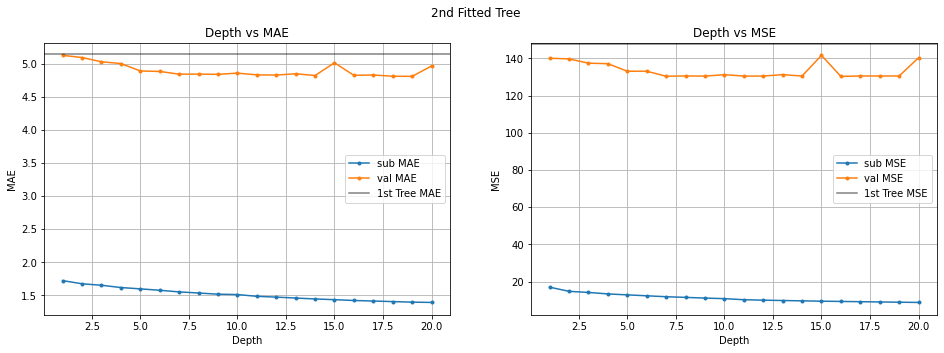

In [55]:
fig, ax = plt.subplots(1, 2, figsize= (16,5))

fig.suptitle("2nd Fitted Tree")

ax[0].plot(depths, train_mae, ".-", label="sub MAE")
ax[0].plot(depths, val_mae, ".-", label="val MAE")
ax[0].axhline(mean_absolute_error(x_val_pred, val.fullPrice), color="black", alpha=0.5, label="1st Tree MAE")
ax[0].set_xlabel("Depth")
ax[0].set_ylabel("MAE")
ax[0].set_title("Depth vs MAE")
ax[0].legend()
ax[0].grid()

ax[1].plot(depths, train_mse, ".-", label="sub MSE")
ax[1].plot(depths, val_mse, ".-", label="val MSE")
ax[1].axhline(mean_squared_error(x_val_pred, val.fullPrice), color="black", alpha=0.5, label="1st Tree MSE")
ax[1].set_xlabel("Depth")
ax[1].set_ylabel("MSE")
ax[1].set_title("Depth vs MSE")
ax[1].legend()
ax[1].grid()

We observe even for small depths there is performance improvement. There is opportunity to apply boosting to our models.

---

<a id="part7"></a>
## STEP 7: Predicting color-FullPrice

### Using same predictors to predict color-FullPrice

In [56]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=45)
rfr.fit(sub[subset_cols], sub["color-FullPrice"])

x_sub_pred = rfr.predict(sub[subset_cols])
x_val_pred = rfr.predict(val[subset_cols])

print("Val MAE:", mean_absolute_error(x_val_pred, val["color-FullPrice"]))
print("Val MSE", mean_squared_error(x_val_pred, val["color-FullPrice"]))

Val MAE: 5.905783646482276
Val MSE 160.6909058801566


---

### Adding color-Description text to predictors

In [57]:
# TopColor doesnt make any sense
# We dont want to include ANY pricing information
# We dont want to include ANY information collected after the release of the shoe

text_cats = ["title", "subtitle", "short_description", "color-Description"]
text_cols = [word for cat in text_cats for word in select_text(cat, df)]
ctgr_cats = ["category", "subcategory", "channel"]
ctgr_cols = [word for cat in ctgr_cats for word in select_text(cat, df)]
othr_cols = ["colorNum","Sustainable"]

new_subset_cols = text_cols + ctgr_cols + othr_cols

In [58]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=45)
rfr.fit(sub[new_subset_cols], sub["color-FullPrice"])

x_sub_pred = rfr.predict(sub[new_subset_cols])
x_val_pred = rfr.predict(val[new_subset_cols])

print("Val MAE:", mean_absolute_error(x_val_pred, val["color-FullPrice"]))
print("Val MSE", mean_squared_error(x_val_pred, val["color-FullPrice"]))

Val MAE: 6.067079929133523
Val MSE 157.77115513578002


Adding color-specific text did not improve predictions.

---

### Adding previous predictions for fullPrice (model stacking)

#### Train our model for fullPrice

In [59]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=45)
rfr.fit(sub[subset_cols], sub.fullPrice)

x_sub_pred = rfr.predict(sub[subset_cols])
x_val_pred = rfr.predict(val[subset_cols])

#### Combine predictions for fullPrice with sub/val sets

In [60]:
sub_stack = pd.concat([
    sub, 
    pd.DataFrame(x_sub_pred, columns=["pred"], index=sub.index),
], axis=1)

val_stack = pd.concat([
    val, 
    pd.DataFrame(x_val_pred, columns=["pred"], index=val.index),
], axis=1)

#### Predict color-FullPrice using our new predictor

In [61]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=45)
rfr.fit(sub_stack[subset_cols + ["pred"]], sub["color-FullPrice"])

x_sub_pred_stack = rfr.predict(sub_stack[subset_cols + ["pred"]])
x_val_pred_stack = rfr.predict(val_stack[subset_cols + ["pred"]])

print("Val MAE:", mean_absolute_error(x_val_pred_stack, val["color-FullPrice"]))
print("Val MSE:", mean_squared_error(x_val_pred_stack, val["color-FullPrice"]))

Val MAE: 4.719297380506827
Val MSE: 119.01962776788191


We observe stacking improves the model performance.

---

<a id="part8"></a>
## STEP 8: Naive Feature Reduction

There is an obvious issue where it takes a long time to train models since the feature space is so large and it is unclear which features are impactful. We could peak at the RandomForest feature importance to get an idea; however, it changes quite often. We can try to train trees on fewer features and see if there is significant change in model performance.

### Rank Feature Importance

In [62]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=45)
rfr.fit(sub[subset_cols], sub["color-FullPrice"])

RandomForestRegressor(max_depth=45)

In [63]:
feature_rank = pd.Series(rfr.feature_importances_, index=subset_cols).sort_values(ascending=False)
feature_rank.head()

title_air           0.166515
subtitle_kids       0.087866
subtitle_toddler    0.069904
subtitle_slides     0.028250
title_vaporfly      0.027840
dtype: float64

In [64]:
train_mae = []
train_mse = []
val_mae = []
val_mse = []

for i in tqdm(range(1, len(feature_rank), 500)):
    sub_cols = feature_rank[:i].index.to_list()
    rfr = RandomForestRegressor(n_estimators=100, max_depth=40)
    rfr.fit(sub[sub_cols], sub.fullPrice)
    
    x_sub_pred = rfr.predict(sub[sub_cols])
    x_val_pred = rfr.predict(val[sub_cols])
    
    train_mae.append(mean_absolute_error(x_sub_pred, sub.fullPrice))
    train_mse.append(mean_squared_error(x_sub_pred, sub.fullPrice))
    val_mae.append(mean_absolute_error(x_val_pred, val.fullPrice))
    val_mse.append(mean_squared_error(x_val_pred, val.fullPrice))
    
    print(i, "MAE:", val_mae[-1])

  9%|▉         | 1/11 [00:00<00:01,  8.33it/s]

1 MAE: 33.933656454182845


 18%|█▊        | 2/11 [00:07<00:20,  2.29s/it]

501 MAE: 5.400834427188646


 27%|██▋       | 3/11 [00:22<00:48,  6.10s/it]

1001 MAE: 5.3533239518769316


 36%|███▋      | 4/11 [00:45<01:17, 11.11s/it]

1501 MAE: 5.143212596745694


 45%|████▌     | 5/11 [01:13<01:38, 16.35s/it]

2001 MAE: 5.244988728404989


 55%|█████▍    | 6/11 [02:25<02:44, 32.83s/it]

2501 MAE: 5.214464294644075


 64%|██████▎   | 7/11 [03:05<02:20, 35.24s/it]

3001 MAE: 5.4204956465246825


 73%|███████▎  | 8/11 [03:50<01:53, 37.90s/it]

3501 MAE: 5.274139507881064


 82%|████████▏ | 9/11 [04:41<01:23, 41.88s/it]

4001 MAE: 5.191130004715895


 91%|█████████ | 10/11 [05:36<00:45, 45.97s/it]

4501 MAE: 5.266855407616357


100%|██████████| 11/11 [06:34<00:00, 35.89s/it]

5001 MAE: 5.135795042567676


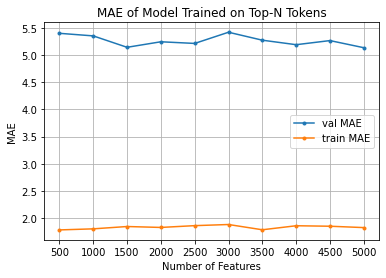

In [65]:
plt.plot(
    list(range(500, len(feature_rank), 500)),
    val_mae[1:], ".-", label="val MAE"
)
plt.plot(
    list(range(500, len(feature_rank), 500)),
    train_mae[1:], ".-", label="train MAE"
)

plt.title("MAE of Model Trained on Top-N Tokens")
plt.xlabel("Number of Features")
plt.ylabel("MAE")
plt.xticks(list(range(500, len(feature_rank), 500)))
plt.grid()
plt.legend()

This naive approach may hint at something interesting: the first few hundred features could be sufficient for modeling.

### Another technique to  try to understand overall category importance is stepwise forward selection

In [66]:
# There are 9 main variables in our X which are a mixture of text, categorical, numerical, and boolean.
# We will try to use some naive form of forward stepwise selection

column_map = {
    "title" : select_text("title", df),
    "subtitle" : select_text("subtitle", df),
    "short_description" : select_text("short_description", df),
    "category" : select_text("category", df),
    "subcategory" : select_text("subcategory", df),
    "channel" : select_text("channel", df),
    "colorNum" : ["colorNum"],
    "Sustainable": ["Sustainable"],
}

remaining = column_map.copy()

In [67]:
cum_mae, cum_mse = [], []
keep = []
keep_cols = {}

# Iterate until all column types consumed
for iteration in range(len(column_map.keys())):
    column_mae, column_mse = {}, {}
    for column_type, csubset in tqdm(remaining.items()):
        csubset = csubset + [c for k, v in keep_cols.items() for c in v]
        
        rfr = RandomForestRegressor(n_estimators=100, max_depth=45)
        rfr.fit(sub[csubset], sub.fullPrice)

        x_train_pred = rfr.predict(sub[csubset])
        x_test_pred = rfr.predict(val[csubset])

        column_mae[column_type] = mean_absolute_error(x_test_pred, val.fullPrice)
        column_mse[column_type] = mean_squared_error(x_test_pred, val.fullPrice)

    best = sorted(column_mae, key=lambda x: column_mae[x])[0]
    keep.append(best)
    keep_cols[best] = remaining.pop(best)
    cum_mae.append(column_mae[best])
    cum_mse.append(column_mse[best])
    
    print(f"{keep} | MAE: {cum_mae[-1]} | MSE: {cum_mse[-1]}")

  0%|          | 0/7 [00:00<?, ?it/s]

['short_description'] | MAE: 7.680897109699776 | MSE: 365.1189268276158


  0%|          | 0/6 [00:00<?, ?it/s]

['short_description', 'subtitle'] | MAE: 6.299967513180774 | MSE: 254.16191206122622


  0%|          | 0/5 [00:00<?, ?it/s]

['short_description', 'subtitle', 'title'] | MAE: 5.061275260465049 | MSE: 143.01975659539121


  0%|          | 0/4 [00:00<?, ?it/s]

['short_description', 'subtitle', 'title', 'category'] | MAE: 4.969454269981004 | MSE: 137.12731122369522


  0%|          | 0/3 [00:00<?, ?it/s]

['short_description', 'subtitle', 'title', 'category', 'colorNum'] | MAE: 5.0291244314582695 | MSE: 138.71418260779475


  0%|          | 0/2 [00:00<?, ?it/s]

['short_description', 'subtitle', 'title', 'category', 'colorNum', 'Sustainable'] | MAE: 5.012882659298482 | MSE: 132.43068206430283


  0%|          | 0/1 [00:00<?, ?it/s]

['short_description', 'subtitle', 'title', 'category', 'colorNum', 'Sustainable', 'subcategory'] | MAE: 4.961228676604332 | MSE: 131.29107182092187


100%|██████████| 1/1 [00:55<00:00, 55.77s/it]

['short_description', 'subtitle', 'title', 'category', 'colorNum', 'Sustainable', 'subcategory', 'channel'] | MAE: 5.068933661264451 | MSE: 134.033553783494


Text(0, 0.5, 'MAE')

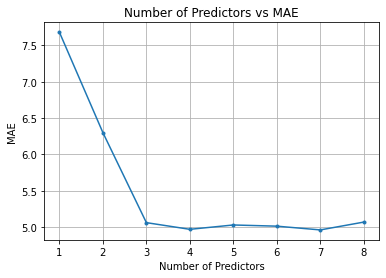

In [68]:
plt.plot(range(1, 9), cum_mae, ".-")
plt.grid()
plt.title("Number of Predictors vs MAE")
plt.xlabel("Number of Predictors")
plt.ylabel("MAE")

Another interesting observation: the most important categories of features are all text!

---